In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$


## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.001
rank_ratio = 0.75
max_iter = 10000

#  $m=n=20$

In [4]:
m = n = 20
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(0.6 * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=4.6267e-03, lamb_max=1.9983e-01, mu_max=7.7112e-03


In [5]:
Z_star_1, Z_star_2, f_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2) \
                          + (mu_reg / 2) * ((Z1).pow(2).sum() + Z2.pow(2).sum())).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-0.0003364081113207658), -0.0003364081203471869, 
cvxpy constraint violation: 1.6391277311150754e-07


In [9]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=0.1998302912978315
A.shape=torch.Size([20, 20]), rank_tol=1.5000e+01, sigma_max=6.3070e-04, fro_norm=1.2415e-03
A.shape=torch.Size([20, 20]), rank_tol=1.5000e+01, sigma_max=6.0435e-04, fro_norm=1.2663e-03
Diagonal PDHG scaling computed.
4.4326e+00 +- 4.5753e-01, 9.0442e+00 +- 1.6014e+00, 9.0549e+00 +- 1.7747e+00
A.shape=torch.Size([20, 20]), rank_tol=2.0000e+01, sigma_max=6.0203e-02, fro_norm=1.3980e-01
A.shape=torch.Size([20, 20]), rank_tol=2.0000e+01, sigma_max=5.4764e-02, fro_norm=1.4279e-01
obj (diag scaling):  -0.0003364081203471869 
constraint viol (diag scaling):  1.6391277311150754e-07
lamb_max=0.1998302912978315
A.shape=torch.Size([20, 20]), rank_tol=1.5000e+01, sigma_max=6.3070e-04, fro_norm=1.2415e-03
A.shape=torch.Size([20, 20]), rank_tol=1.5000e+01, sigma_max=6.0435e-04, fro_norm=1.2663e-03
obj (vanilla):  -0.00033640809124335647 
constraint viol (vanilla):  4.749745128457272e-08
lamb_max=0.1998302912978315
A.shape=torch.Size([20, 20]), rank_tol=1.5000e+01, sigma_

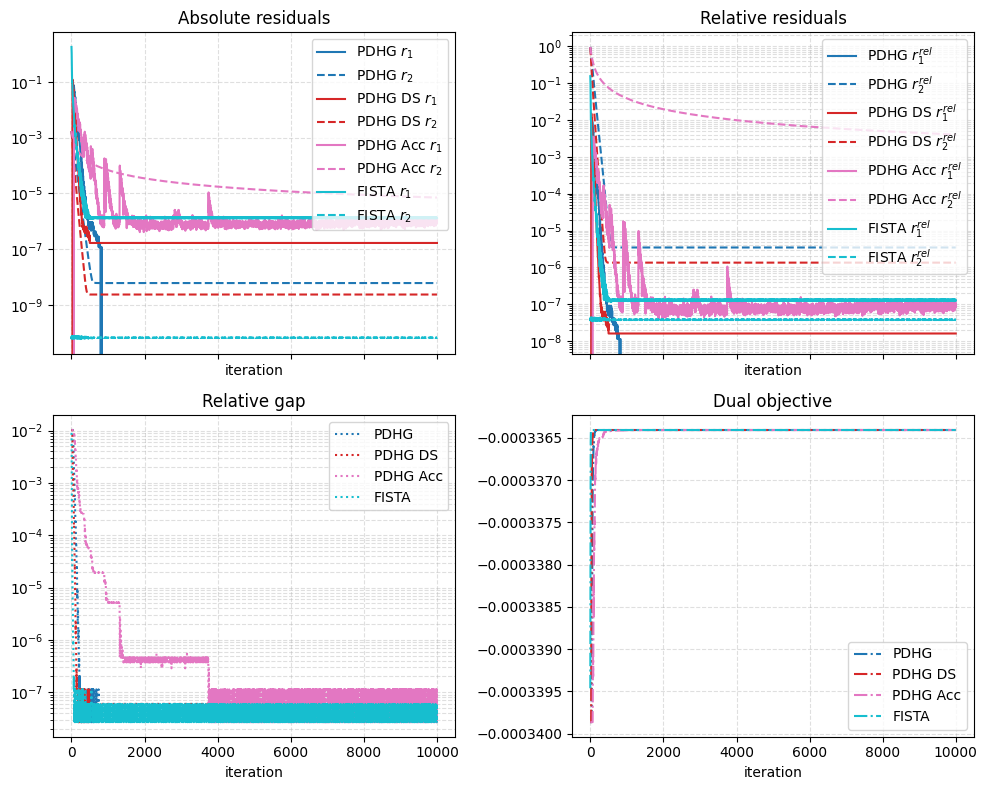

In [10]:
plot_residuals_compare(residuals, dpi=100)

#  $m=n=1000$

In [11]:
m = n = 1000
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(0.6 * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=1.1237e-03, lamb_max=9.9944e+00, mu_max=1.8728e-03


In [12]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, pd_residuals=pd_residuals_infty_ball)

lamb_max=9.994384279787475
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0705e-04, fro_norm=1.2541e-03
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0768e-04, fro_norm=1.2540e-03
Diagonal PDHG scaling computed.
8.7781e-02 +- 1.4992e-03, 1.7566e-01 +- 4.2387e-03, 1.7556e-01 +- 4.1189e-03
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4383e-01, fro_norm=7.0707e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4624e-01, fro_norm=7.0635e+00
obj (diag scaling):  -0.0013721755240112543 
constraint viol (diag scaling):  0.0007965611293911726
lamb_max=9.994384279787475
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0705e-04, fro_norm=1.2541e-03
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0768e-04, fro_norm=1.2540e-03
obj (vanilla):  -0.0012483196333050728 
constraint viol (vanilla):  0.0013144928961992056
lamb_max=9.994384279787475
A.shape=torch.Size([1000, 1000]), rank

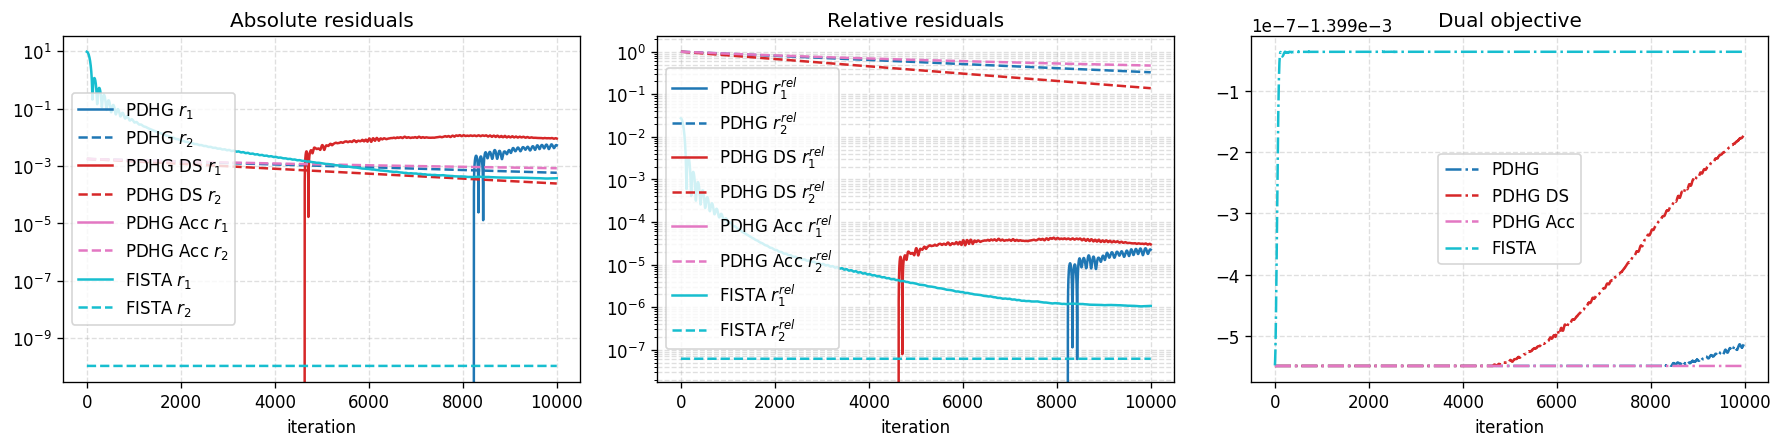

In [13]:
plot_residuals_compare(residuals)

#  $m=n=1000$

In [14]:
m = n = 1000
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=rank_ratio)
beta = 0.001

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(0.6 * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=1.1314e-03, lamb_max=1.0003e+01, mu_max=1.8856e-03


In [15]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            max_iter=max_iter, stopping=False, pd_residuals=pd_residuals_infty_ball)

lamb_max=10.00295757054621
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0849e-04, fro_norm=1.2542e-03
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0869e-04, fro_norm=1.2538e-03
Diagonal PDHG scaling computed.
8.7715e-02 +- 1.4905e-03, 1.7539e-01 +- 4.0981e-03, 1.7557e-01 +- 4.1966e-03
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4591e-01, fro_norm=7.0688e+00
A.shape=torch.Size([1000, 1000]), rank_tol=1.0000e+03, sigma_max=4.4730e-01, fro_norm=7.0775e+00
obj (diag scaling):  -0.0013634561328217387 
constraint viol (diag scaling):  0.0007834061980247289
lamb_max=10.00295757054621
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0849e-04, fro_norm=1.2542e-03
A.shape=torch.Size([1000, 1000]), rank_tol=7.5000e+02, sigma_max=1.0869e-04, fro_norm=1.2538e-03
obj (vanilla):  -0.0012419664999470115 
constraint viol (vanilla):  0.0016883024945854933
lamb_max=10.00295757054621
A.shape=torch.Size([1000, 1000]), rank

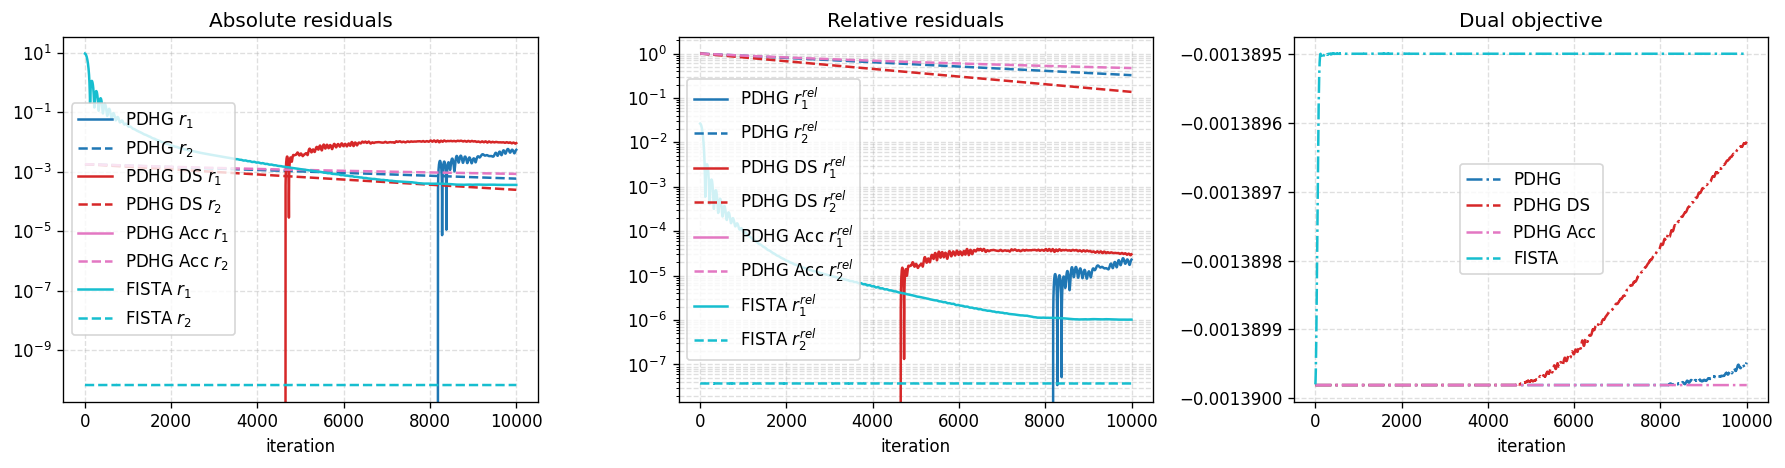

In [16]:
plot_residuals_compare(residuals)